<i>Notebook Author: Trenton McKinney

Course: DataCamp: Fraud Detection in Python

This notebook was created as a reproducible reference.

This exercise uses parts of McKinney's notebook. Some comments and questions have been added by RK.

<h4>Fraud detection with unlabeled data </h4>
    
We use bank payment transaction data. We first visualize the data and segment the customers. Then, we use K-means and DBSCAN clustering methods to find outliers, i.e., possible fraudulent occurences. 
    
Fraud detection with unlabeled data is difficult for several reasons. It is difficult to validate and abnormal behavior is not necessary fraudulent. 
    
We start by looking at the data to understand what is normal, what is abnormal and what kind of segmentation we should use. 

Then, we normalize the data and use K-means clustering. We try to find the optimal number of clusters. Once we have a suitable amount of clusters, we search the outliers. We test our assumption that outliers are fradulent transactions. 

Finally, we apply DBSCAN. We assume that the smallest clusters might contain data on fradulent transactions. We test our assumption with some labeled data. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
from pprint import pprint as pp
import csv
from pathlib import Path
import seaborn as sns
from itertools import product
import string

from imblearn.pipeline import Pipeline 

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.metrics import homogeneity_score, silhouette_score, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import MiniBatchKMeans, DBSCAN

In [2]:
pd.set_option('display.max_columns', 700)
pd.set_option('display.max_rows', 400)
pd.set_option('display.min_rows', 10)
pd.set_option('display.expand_frame_repr', True)

In [5]:
banksim_file = 'banksim.csv'
banksim_adj_file ='banksim_adj.csv'

We read the data from the files banksim_file and banksim_ad.
Then, we try to understand from the data what is normal and what is abnormal. 


In [6]:
banksim_df = pd.read_csv(banksim_file, usecols=lambda x: x != 'Unnamed: 0')
banksim_adj_df = pd.read_csv(banksim_adj_file, usecols=lambda x: x != 'Unnamed: 0')

Lets first print the shape and the first rows of both dataframes to see what data we have. 

In [7]:
# print the shape and the first rows of both dataframes
print(banksim_df.shape)
banksim_df.head()

(7200, 5)


,age,gender,category,amount,fraud
0,3,F,es_transportation,49.71,0
1,4,F,es_health,39.29,0
2,3,F,es_transportation,18.76,0
3,4,M,es_transportation,13.95,0
4,2,M,es_transportation,49.87,0


In [8]:
print(banksim_adj_df.shape)
banksim_adj_df.head()

(7189, 18)


,age,amount,fraud,M,es_barsandrestaurants,es_contents,es_fashion,es_food,es_health,es_home,es_hotelservices,es_hyper,es_leisure,es_otherservices,es_sportsandtoys,es_tech,es_transportation,es_travel
0,3,49.71,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,4,39.29,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,3,18.76,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,4,13.95,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,2,49.87,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0


Some transactions are labeled as fraud. We group the data of banksim_df by transaction category ('category') and take the mean of the data.
You can use the method 'df.groupby'. The correct piece of code is in the end of this exercise.

In [9]:
# group the data here
banksim_df.groupby('category').agg({'amount': 'mean', 'fraud': 'mean'})

,amount,fraud
category,,
es_barsandrestaurants,43.841793,0.022472
es_contents,55.170000,0.000000
es_fashion,59.780769,0.020619
es_food,35.216050,0.000000
es_health,126.604704,0.242798
es_home,120.688317,0.208333
es_hotelservices,172.756245,0.548387
es_hyper,46.788180,0.125000
es_leisure,229.757600,1.000000


Q: according to the results, in which categories do the majority of fraud occur?


Leisure and travel have the highest fraud occurance

We then do customer segmentation. Unfortunately, there is not much information availabe. We group the data of banksim_df by age and compute the mean of each 6 age group. 

In [10]:
# group here
banksim_df.groupby('age').agg({'amount': 'mean', 'fraud': 'mean'})

,amount,fraud
age,,
0,49.468935,0.050000
1,35.622829,0.026648
2,37.228665,0.028718
3,37.279338,0.023283
4,36.197985,0.035966
5,37.547521,0.023990
6,36.700852,0.022293
U,39.117000,0.000000


Then, we count the values of each age group. You can use 'value_counts'. 

In [11]:
banksim_df.age.value_counts()

age
2    2333
3    1718
4    1279
5     792
1     713
6     314
0      40
U      11
Name: count, dtype: int64

Q: based on the results, there is no reason to split the data. Explain why. Look at both of the two boxes above. 

In all the age groups, amount spent and average fraud is roughly similar so we dont know how to cluster them.

We then use statistics to define normal behavior. 

We create two dataframes with fraud and non-fraud data from banksim_df. This piece of code is in the end of the exercise as it is so crucial. We plot two histograms, using df_fraud.amount and df_non_fraud.amount. 

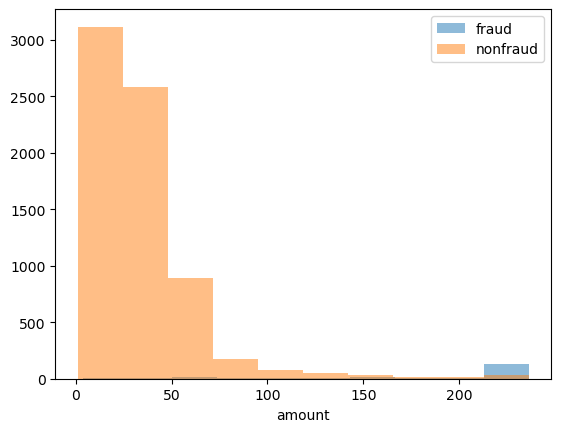

In [12]:
# Create two dataframes with fraud and non-fraud data 
df_fraud = banksim_df[banksim_df.fraud == 1] 
df_non_fraud = banksim_df[banksim_df.fraud == 0]

# Plot histograms of the amounts in fraud and non-fraud data 
plt.hist(df_fraud.amount, alpha=0.5, label='fraud')
plt.hist(df_non_fraud.amount, alpha=0.5, label='nonfraud')
plt.xlabel('amount')
plt.legend()
plt.show()

Q: Look at the histograms. What can you say about the fradulent transactions, based on the x-axis (amount of money)?

The histogram is skewed to the left. Fraud occurs for small amounts of money a lot more.

Clustering to detect fraud

We transform the dataframe banksim_adj_df into a numpy array X by taking only the values of df and make sure you have all float values.
We apply the defined scaler onto X to obtain scaled values of X_scaled to force all your features to a 0-1 scale.
We store the fraud labels separately under 'labels'.

In [13]:
labels = banksim_adj_df.fraud

In [14]:
# Take the float values of df for X
X = banksim_adj_df.drop(columns=['fraud']).values.astype(float)
 
X.shape

(7189, 17)

Lets then define the scaler MinMaxScaler() to X to obtain scaled values of X_scaled.

In [15]:
# Define the scaler and apply to the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

K-mean clustering

Initialize the minibatch kmeans model with 8 clusters. You can set random_state=0
Fit the model to your scaled data.

In [16]:
# Define the model 
kmeans = MiniBatchKMeans(n_clusters=8, random_state=0, max_no_improvement=10)

# Fit the model to the scaled data
kmeans.fit(X_scaled)

/opt/software/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


MiniBatchKMeans(random_state=0)

Then, we want to know the optimal number of clusters for this problem. Define the range to be between 1 and 10 clusters.
Run MiniBatch K-means on all the clusters. You can use list comprehension.
Fit each model on the scaled data and obtain the scores from the scaled data.
Plot the cluster numbers and their respective scores.

In [17]:
# Define the range of clusters to try
clustno = range(1, 10)

# Run MiniBatch Kmeans over the number of clusters
kmeans = [MiniBatchKMeans(n_clusters=i) for i in clustno]

# Obtain the score for each model
score = [kmeans[i].fit(X_scaled).score(X_scaled) for i in range(len(kmeans))]

/opt/software/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
/opt/software/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
/opt/software/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
/opt/software/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_ini

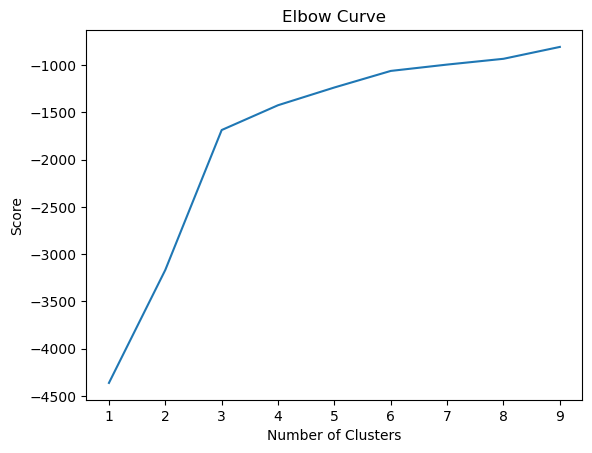

In [18]:
# Plot the models and their respective score  (picture Elbow curve in the exercise paper)
fig, ax = plt.subplots()
ax.plot(clustno, score)
ax.set(xlabel='Number of Clusters', ylabel='Score', title='Elbow Curve')
plt.show()

Detecting outliers

Split the scaled data and labels y into a train and test set.
Define the MiniBatch K-means model with 3 clusters, and fit to the training data.
Get the cluster predictions from your test data and obtain the cluster centroids.
Define the boundary between fraud and non fraud to be at 95% of distance distribution and higher.  (this last piece of code is given in the end of the exercise for those who haven't coded much.)

In [26]:
# Split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, labels, test_size=0.3, random_state=0)

# Define K-means model 
kmeans = MiniBatchKMeans(n_clusters=3,  n_init='auto', random_state=42).fit(X_train)

# Obtain predictions  
X_test_clusters = kmeans.predict(X_test)
X_test_clusters_centers = kmeans.cluster_centers_

# calculate distance from cluster centroid
dist = [np.linalg.norm(x-y) for x, y in zip(X_test, X_test_clusters_centers[X_test_clusters])]

# Create fraud predictions based on outliers on clusters 
km_y_pred = np.array(dist)
km_y_pred[dist >= np.percentile(dist, 95)] = 1
km_y_pred[dist < np.percentile(dist, 95)] = 0

Confusion matrix

First, create a confusion matrix from the test labels y_test and predicted labels km_y_pred.

In [27]:
# Create a confusion matrix
km_cm = confusion_matrix(y_test, km_y_pred)

We can plot the confusion matrix with the following code. Call this function with both normalized and non-normalized data and plot the result. 

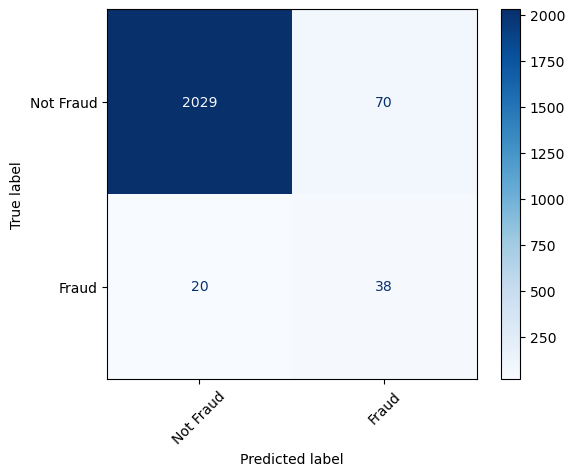

In [28]:
disp = ConfusionMatrixDisplay(confusion_matrix=km_cm,
                             display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap='Blues')
plt.xticks(rotation=45)
plt.show()

Q: If you were to decrease the percentile used as a cutoff point in the previous exercise to 93% instead of 95%, what would that do to your prediction results?

We compute Area Under the Receiver Operating Characteristic Curve 'roc_auc_score' from prediction scores km_y_pred.
Q: What does this score tell us?

If we decrease the percentile to 93%, we lower the threshold for considering an instance as an outlier. So, more instances will be classified as fraud, as the distance from the cluster centroids needed to be considered an outlier becomes smaller. We see non fruad cases (from 2029 to 1988). 
A higher AUC-ROC score indicates better discrimination and a more accurate model in distinguishing between the positive and negative classes. Here, ROC changed from 0.81 to 0.82.

In [30]:
# Obtain the ROC score
roc_auc_score(y_test, km_y_pred)

0.8109115999408585

DBSCAN model

K-means works well when the data is clustered in normal, round shapes. Small clusters can be an indication of fraud. We next try DBSCABN. This method might have several advantages compared to KMeans. We don't need to define the number of clusters beforehand. The algorithm finds core samples of high density and expands clusters from them. 
DBSCAN can handle non-convex data better than KMeans. It is computationally heavier then MiniBatch K-means.

We try the following: We form clusters with DBScan and assume that the smallest clusters are fraud. We test our assumption using the labeled y_test data. 

Set the maximum distance between two samples to 0.9 and the minimum observations in the clusters to 10. Fit DBSCAN to scaled data X_scaled.
Use 'labels_' method to get the assigned cluster label for each data point.
Calculate the number of clusters. (this piece of code is in the end of the exercise). You can plot a histogram of the clusters. 

In [32]:
# Initialize and fit the DBscan model
db = DBSCAN(eps=0.9, min_samples=10, n_jobs=-1).fit(X_scaled)

# Obtain the predicted labels and calculate number of clusters
pred_labels = db.labels_
n_clusters = len(set(pred_labels)) - (1 if -1 in labels else 0)


Estimated number of clusters: 23
Homogeneity: 0.612
Silhouette Coefficient: 0.713


(array([3450., 2769.,  293.,  220.,   69.,  134.,   76.,   89.,   40.,
          49.]),
 array([-1. ,  1.2,  3.4,  5.6,  7.8, 10. , 12.2, 14.4, 16.6, 18.8, 21. ]),
 <BarContainer object of 10 artists>)

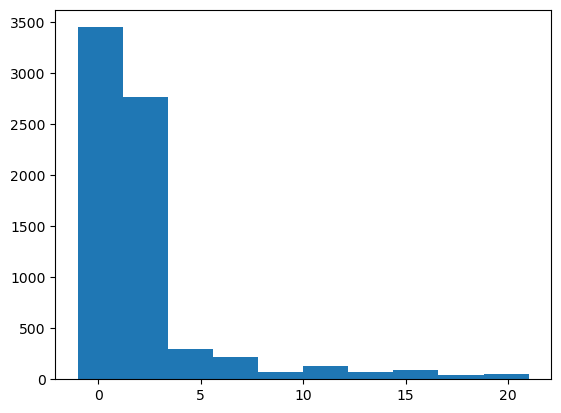

In [33]:
# Print performance metrics for DBscan
print(f'Estimated number of clusters: {n_clusters}')
print(f'Homogeneity: {homogeneity_score(labels, pred_labels):0.3f}')
print(f'Silhouette Coefficient: {silhouette_score(X_scaled, pred_labels):0.3f}')

# Print a histogram of the predicted labels. 
plt.hist(pred_labels)

Q: What are the homgeneity score and the Silhouette coefficient?

The homogeneity score measures the degree to which each cluster contains only members of a single clas where 0 indicates low homogeneity (clusters contain a mix of different classes) and 1 indicates high homogeneity (each cluster contains only instances of a single class)

The Silhouette coefficient measures how similar an object is to its own cluster (cohesion) compared to other clusters (separation). It provides a measure of how well-separated clusters are and how appropriate the assignment of data points to clusters is. It ranges from -1 to 1, where a high value indicates well-defined clusters, a value near 0 suggests overlapping clusters, and negative values indicate that data points may have been assigned to the wrong cluster.

Next, count observations in each cluster and take the 3 smallest clusters. Print the smallest clusters and their counts. 
You can use np.bincount and np-argsort. 

In [34]:
# Count observations in each cluster number
counts = np.bincount(pred_labels[pred_labels >= 0])

# Print the result
print(counts)

[3252  145 2714   55  174  119  122   98   54   15   76   15   43   25
   51   47   42   15   25   20   19   10]


In [35]:
# Sort the sample counts of the clusters and take the top 3 smallest clusters
smallest_clusters = np.argsort(counts)[:3]

In [36]:
# Print the results 
print(f'The smallest clusters are clusters: {smallest_clusters}')

The smallest clusters are clusters: [21 17  9]


In [37]:
# Print the counts of the smallest clusters only
print(f'Their counts are: {counts[smallest_clusters]}')

Their counts are: [10 15 15]


Create a dataframe of the predicted cluster numbers and fraud labels. You can call the columns  'clusternr' and 'fraud'. 

Then, add a third column in the dataframe, 'predicted_fraud'. We assume that the smallest clusters contain fradulent transactions. You can create  a condition flagging fraud for the smallest clusters  (you can use np.where and isin). This piece of code is in the end of the exercise. 

In [38]:
# Create a dataframe of the predicted cluster numbers and fraud labels 
df = pd.DataFrame({'clusternr':pred_labels,'fraud':labels})

# Create a condition flagging fraud for the smallest clusters 
df['predicted_fraud'] = np.where((df['clusternr'].isin([21, 17, 9])), 1 , 0)
df.head()

,clusternr,fraud,predicted_fraud
0,0,0,0
1,1,0,0
2,0,0,0
3,2,0,0
4,2,0,0


Run a crosstab on the results. Q: How would you analyse the result? Compare it with the result of MiniBatchKMeans.

In [39]:
# Run a crosstab on the results 
print(pd.crosstab(df['fraud'], df['predicted_fraud'], rownames=['Actual Fraud'], colnames=['Flagged Fraud']))

Flagged Fraud     0   1
Actual Fraud           
0              6973  16
1               176  24


Fraud cases are identified less precisely. however we have relatively low number of fraud cases in both cases. many more cases have made into the list of non fraud cases.